# Imports

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stl_filter import *
import json
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

SEED=12
np.random.seed(SEED)

# %matplotlib inline

# Data

In [93]:
# train_df = pd.read_csv("sales_train_evaluation.csv")
# train_df.shape

In [94]:
# val_df = pd.read_csv("sales_train_validation.csv")
# val_df.shape

In [2]:
passengers_df = pd.read_csv("air-passengers.csv")
display(passengers_df.shape)
display(passengers_df.head())

# # Параметры шума
# noise_lst = [0.15, 0.1, 0.05] # Уровень шума (5% от значений)
# for noise_level in noise_lst:
#     noise = np.random.normal(0, noise_level * passengers_df['Passengers'].mean(), len(passengers_df))

#     # Добавление шума
#     passengers_df[f'Passengers_Noisy_{noise_level}_seed{SEED}'] = passengers_df['Passengers'] + noise
#     passengers_df[f'Passengers_Noisy_{noise_level}_seed{SEED}'] = passengers_df[f'Passengers_Noisy_{noise_level}_seed{SEED}'].round().astype(int)  # Округление до целых

# passengers_df.head()

(144, 5)

,Month,Passengers,Passengers_Noisy_0.15_seed17,Passengers_Noisy_0.1_seed17,Passengers_Noisy_0.05_seed17
0,1949-01,112,84,66,94
1,1949-02,118,94,82,110
2,1949-03,132,139,102,134
3,1949-04,129,163,137,129
4,1949-05,121,144,98,116


In [96]:
# #2985 сезонный ряд, тк видим повторяющийся паттерн каждые 7 лагов

# #1337 HOUSEHOLD_2_242_CA_1_evaluation ряд шумный
# #28581 HOUSEHOLD_2_044_WI_3_evaluation только тренд
# #30426 FOODS_3_764_WI_3_evaluation трендом, сезонностю(годовая) + шум
# #2810 FOODS_3_586_CA_1_evaluation сезонность(годовая) + шум
# #air-passengers тренд + сезонность(месячная)
# def plot_series(indx_lst: list, with_stl_decomposition: bool = False):
#     '''рисует ряды, указанные в indx_lst
#     indx_lst - список индексов рядов в train_df, которые нужно нарисовать
#     '''

#     if not with_stl_decomposition:

#         plt.figure(figsize=(10, 2 * len(indx_lst)))
#         for i, ind in enumerate(indx_lst):
#             plt.subplot(len(indx_lst), 1, i + 1)
#             row = train_df.iloc[ind]
#             series_id = row["id"]
#             var = np.var(train_df.drop(columns=["id","item_id", "dept_id", "cat_id", "store_id", "state_id"]).iloc[ind].values)
#             plt.plot(train_df.drop(columns=["id","item_id", "dept_id", "cat_id", "store_id", "state_id"]).iloc[ind].values)
#             plt.title(f"{ind} {series_id}, var= {var:.2f}")
#             plt.xlabel("Day")
#             plt.ylabel("Units sold")
            
    
#     else:
#         plt.figure(figsize=(11, 5 * len(indx_lst)))
#         for ind in indx_lst:
#             result = calculate_stl_features(train_df.iloc[ind].filter(like='d_'), period=365)
#             result['stl_result'].plot()
#             plt.suptitle(train_df.iloc[ind]["id"], fontsize=11)
#     plt.tight_layout()
#     plt.show()

# # plot_series([1337, 28581, 30426, 2810])

In [97]:
# #1337 HOUSEHOLD_2_242_CA_1_evaluation ряд шумный
# #28581 HOUSEHOLD_2_044_WI_3_evaluation только тренд
# #30426 FOODS_3_764_WI_3_evaluation трендом, сезонностю(годовая) + шум
# #2810 FOODS_3_586_CA_1_evaluation сезонность(годовая) + шум
# #air-passengers тренд + сезонность(месячная)
# plot_series([30426], with_stl_decomposition=True)

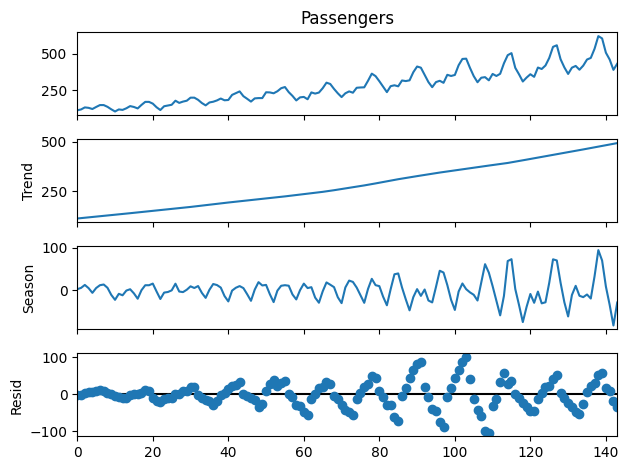

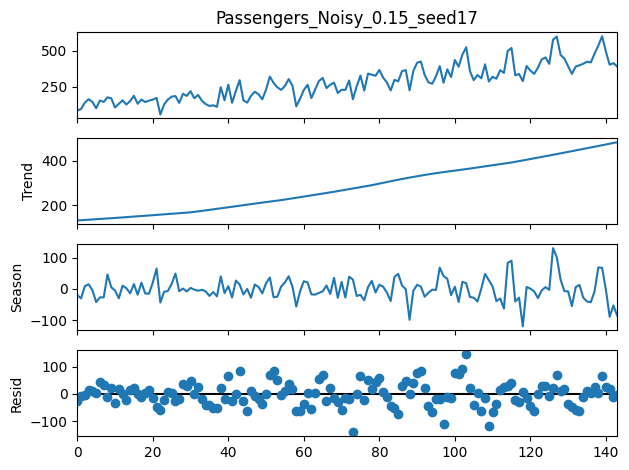

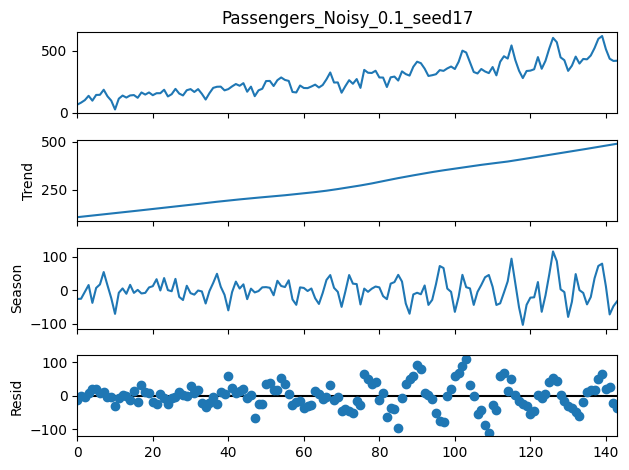

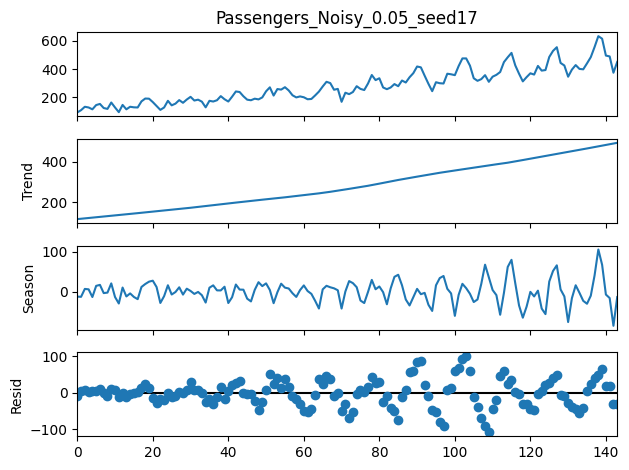

In [98]:
passenger_columns = [col for col in passengers_df.columns if col.startswith("Passengers")]
for col in passenger_columns:
    result = calculate_stl_features(passengers_df[col], period=30)
    result['stl_result'].plot()
plt.show()


# passengers_df.to_csv('air-passengers.csv', index=False)

# AutoArima

In [3]:
from sktime.forecasting.arima import AutoARIMA
QUANTILES = [0.05, 0.25, 0.5, 0.75, 0.95]
model = AutoARIMA(sp=12, max_p=100, max_q=100, suppress_warnings=True, random_state=413)
y = passengers_df["Passengers"].values
train_data = y[:-28]
model.fit(train_data)
naive_pred = model.predict(fh=np.arange(1, 28+1)).flatten()
naive_quantile_pred = model.predict_quantiles(fh=np.arange(1, 28+1), alpha=QUANTILES)

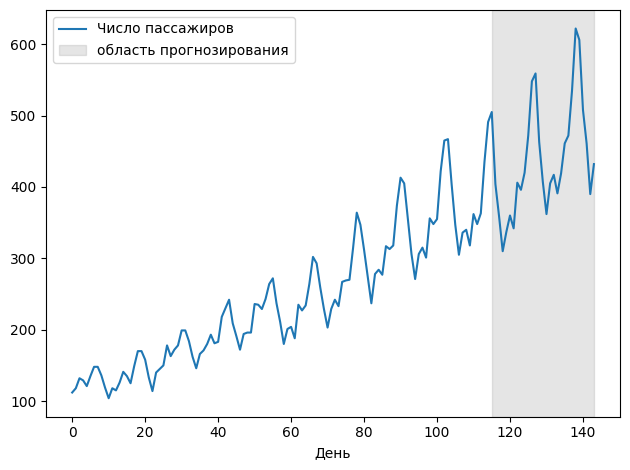

In [8]:
plt.plot(y, label='Число пассажиров')
plt.xlabel('День')
plt.axvspan(len(train_data) - 1, len(y) - 1, color='#808080', alpha=0.2, label='область прогнозирования')


plt.legend()
plt.tight_layout()
plt.show()

In [12]:
from tqdm import tqdm
rolling_model = AutoARIMA(sp=12, max_p=100, max_q=100, suppress_warnings=True, random_state=413)
rolling_model.fit(train_data)
q = rolling_model.get_fitted_params()['order'][-1]
rolling_pred = [rolling_model.predict(fh=np.arange(1, max(q, 1)+1))]

rolling_quantile_pred = [rolling_model.predict_quantiles(fh=np.arange(1, max(q, 1)+1), alpha=QUANTILES)]

for i in tqdm(range(len(train_data) + max(q, 1), len(y), max(q, 1))):
    rolling_model.fit(y[:i])
    rolling_pred.append(rolling_model.predict(fh=list(range(1, max(q, 1)+1))))
    rolling_quantile_pred.append(rolling_model.predict_quantiles(fh=np.arange(1, max(q, 1)+1), alpha=QUANTILES))
    
rolling_quantile_pred = pd.concat(rolling_quantile_pred)
rolling_pred = np.concatenate(rolling_pred).flatten()



100%|██████████| 27/27 [06:59<00:00, 15.53s/it]


naive pl: [ 5.11973679 11.10553096  9.82142857  8.92620119  4.1082961 ]
rolling pl: [2.73138134 5.86495555 7.13782285 5.4400992  2.34194916]



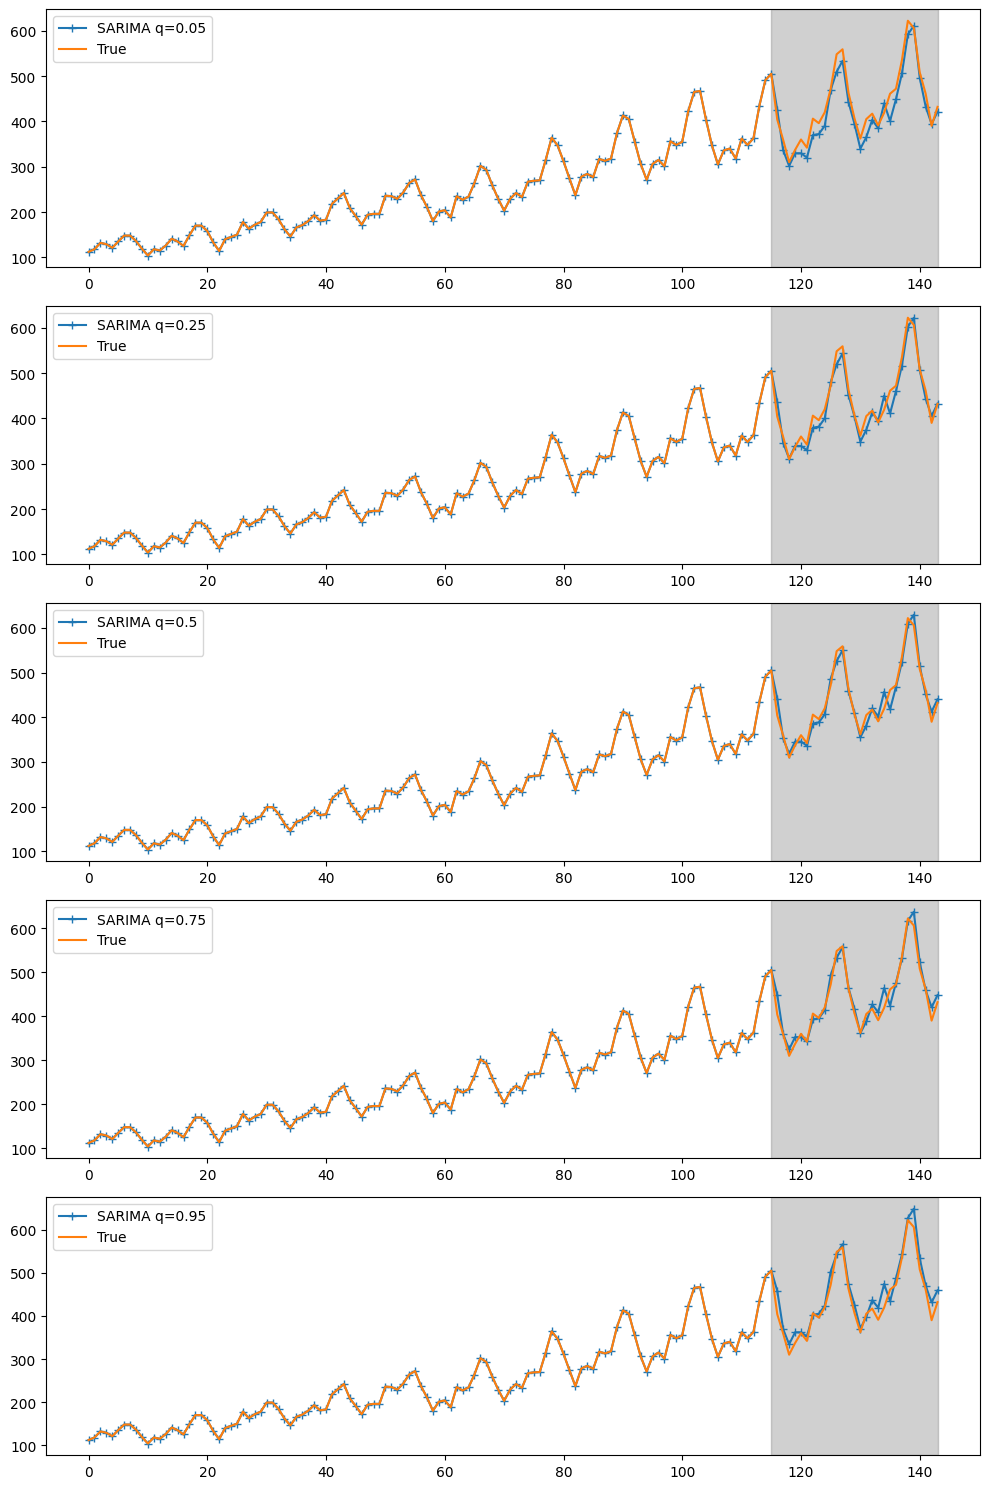

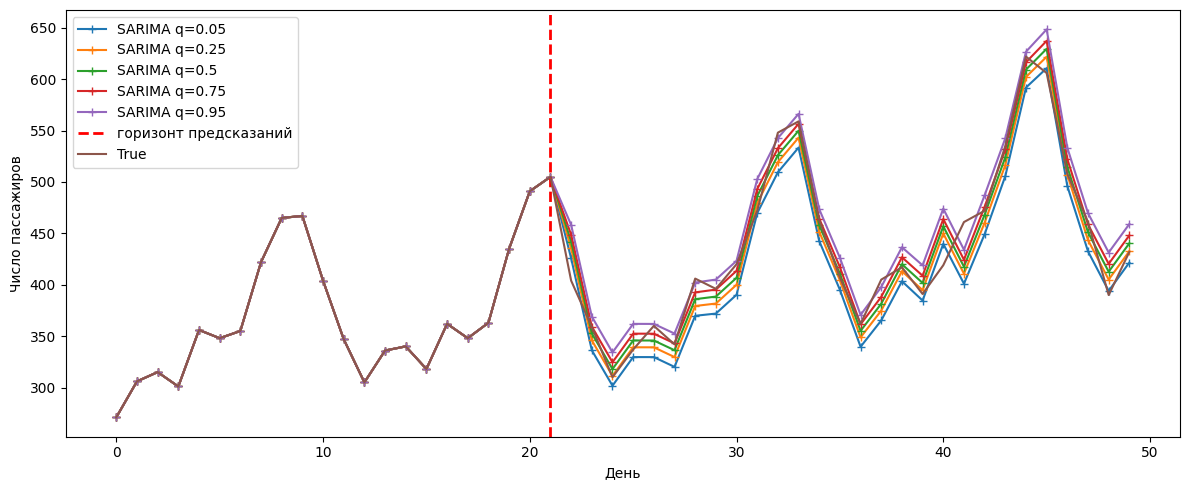

RMSE: 23.5190
R2: 0.9103
MAE: 19.6429

RMSE: 17.8524
R2: 0.9483
MAE: 14.2756



In [42]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss
pl = PinballLoss(score_average=False)
print(f'naive pl: {pl(y[-28:], naive_quantile_pred).to_numpy()}')
print(f'rolling pl: {pl(y[-28:], rolling_quantile_pred).to_numpy()}\n')
fig, axes = plt.subplots(len(QUANTILES), 1, figsize=(10, 15))
for ax, quantile in zip(axes.flatten(), QUANTILES):
    
    for name in ('Rolling', "Naive"):
        if name == 'Rolling':
            # ax.plot(np.concatenate((train_data, rolling_pred))[-70:], '--',label='SARIMA point')
            ax.plot(np.concatenate((train_data, list(rolling_quantile_pred.to_dict()[(0, quantile)].values()))), '+-',label=f'SARIMA q={quantile}')
        # else:
        #     ax.plot(np.concatenate((train_data, naive_pred)), '--',label='Naive pred')
        #     ax.plot(np.concatenate((train_data, list(naive_quantile_pred.to_dict()[(0, quantile)].values()))), '+-',label=f'Naive q={quantile}')
        ax.axvspan(len(train_data) - 1, len(y) - 1, color='#808080', alpha=0.2)
    ax.plot(y, label='True')
    ax.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for quantile in QUANTILES:
    plt.plot(np.concatenate((train_data, list(rolling_quantile_pred.to_dict()[(0, quantile)].values())))[-50:], '+-',label=f'SARIMA q={quantile}')
plt.axvline(x=21, color='r', linestyle='--', linewidth=2, label='горизонт предсказаний')
plt.plot(y[-50:], label='True')
plt.xlabel('День')
plt.ylabel('Число пассажиров')

plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
for preds in [naive_pred, rolling_pred]:
    print(f'RMSE: {root_mean_squared_error(y_true=y[-28:], y_pred=preds):.4f}')
    print(f"R2: {r2_score(y_true=y[-28:], y_pred=preds):.4f}")
    print(f"MAE: {mean_absolute_error(y[-28:], y_pred=preds):.4f}\n")

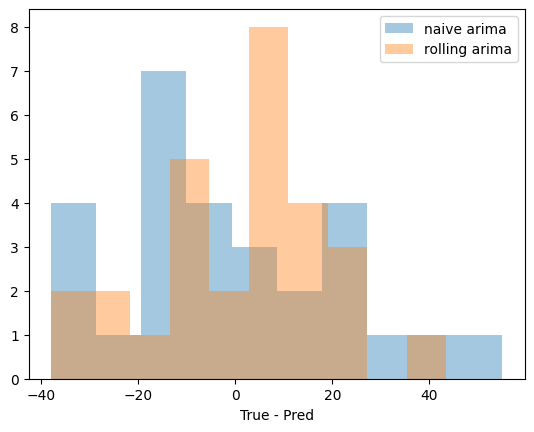

In [13]:
for name, preds in zip(('naive arima', 'rolling arima'), [naive_pred, rolling_pred]):
    residuals = y[-28:] - preds
    plt.hist(residuals, label=name, alpha=0.4)
plt.xlabel("True - Pred")
plt.legend()
plt.show()

# LightGBM

In [44]:
y = passengers_df["Passengers"].values
lags=[1, 2, 3, 7, 14, 30]
rolling_windows=[3, 7, 14, 30]
diff_periods=[1, 2, 3, 7, 14, 30]

df = pd.DataFrame({'target': y})
    
for lag in lags:
    df[f'lag_{lag}'] = df['target'].shift(lag)

for window in rolling_windows:
    df[f'rolling_mean_{window}'] = df['target'].shift(1).rolling(window=window).mean()
    df[f'rolling_std_{window}'] = df['target'].shift(1).rolling(window=window).std()


for period in diff_periods:
    df[f'diff_{period}'] = df['target'].diff(period)

df['target_future'] = df['target'].shift(-1)
df = df.iloc[:-1]

# df = df.dropna() #########3
display(df.shape)
display(df.head())

X = df.drop(columns=['target', 'target_future'])
y_target = df['target_future']

X_train, X_test = X[:-28], X[-28:]
y_train, y_test = y_target[:-28], y_target[-28:]
print(f"\nРазмеры данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

(143, 22)

,target,lag_1,lag_2,lag_3,lag_7,lag_14,lag_30,rolling_mean_3,rolling_std_3,rolling_mean_7,...,rolling_std_14,rolling_mean_30,rolling_std_30,diff_1,diff_2,diff_3,diff_7,diff_14,diff_30,target_future
0,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.0
1,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,132.0
2,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.0,20.0,NaN,NaN,NaN,NaN,129.0
3,129,132.0,118.0,112.0,NaN,NaN,NaN,120.666667,10.263203,NaN,...,NaN,NaN,NaN,-3.0,11.0,17.0,NaN,NaN,NaN,121.0
4,121,129.0,132.0,118.0,NaN,NaN,NaN,126.333333,7.371115,NaN,...,NaN,NaN,NaN,-8.0,-11.0,3.0,NaN,NaN,NaN,135.0



Размеры данных:
X_train: (115, 20), y_train: (115,)
X_test: (28, 20), y_test: (28,)


In [47]:
from catboost import CatBoostRegressor
models = {}
predictions = {}
rolling_predictions = {}
eval_results = {}

param_grid = {
    'depth': [4, 6, 8, 10],                    # Глубина деревьев
    'l2_leaf_reg': [1, 3, 5, 7, 10],          # L2 регуляризация
    'learning_rate': [0.01, 0.03, 0.05, 0.1], # Скорость обучения
    'iterations': [500, 1000, 1500],           # Количество итераций
    'random_strength': [0.1, 0.5, 1],         # Случайность при выборе разделений
    'bagging_temperature': [0, 0.5, 1],       # Температура бэггинга
    'leaf_estimation_iterations': [1, 5, 10], # Итерации для оценки листьев
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'] # Стратегия роста
}

for alpha in QUANTILES:
    print(f"\nОбучаем CatBoost для квантиля {alpha}...")

    model = CatBoostRegressor(
        loss_function=f'Quantile:alpha={alpha}',
        iterations=50_000,
        learning_rate=1e-2,
        depth=2,
        l2_leaf_reg=3,
        random_seed=SEED,
        verbose=100,  # Показываем прогресс каждые 100 итераций
        early_stopping_rounds=2_000,
        task_type='CPU'  # Можно изменить на 'GPU' если есть 
        
    )
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=False,  # Можно установить True для визуализации обучения
        verbose_eval=0
    )
    predictions[alpha] = model.predict(X_test)
    models[alpha] = model

    HORIZON = 4
    rolling_pred = [model.predict(X_test[:HORIZON])]
    for i in tqdm(range(len(y_train) + HORIZON, len(y_target), HORIZON)):
        print(i, i+HORIZON)
        model.fit(
            X[:i], y_target[:i],
            eval_set=(X[i:], y_target[i:]),
            plot=False,  # Можно установить True для визуализации обучения
            verbose_eval=0
        )
        rolling_pred.append(model.predict(X[i:i+HORIZON]))
    rolling_predictions[alpha] = np.concatenate(rolling_pred)
    
    
    


Обучаем CatBoost для квантиля 0.05...


  0%|          | 0/6 [00:00<?, ?it/s]

119 123


 17%|█▋        | 1/6 [00:04<00:20,  4.17s/it]

123 127


 33%|███▎      | 2/6 [00:07<00:13,  3.43s/it]

127 131


 50%|█████     | 3/6 [00:09<00:08,  2.99s/it]

131 135


 67%|██████▋   | 4/6 [00:15<00:08,  4.20s/it]

135 139


 83%|████████▎ | 5/6 [00:18<00:03,  3.71s/it]

139 143


100%|██████████| 6/6 [00:20<00:00,  3.43s/it]



Обучаем CatBoost для квантиля 0.25...


  0%|          | 0/6 [00:00<?, ?it/s]

119 123


 17%|█▋        | 1/6 [00:20<01:44, 20.90s/it]

123 127


 33%|███▎      | 2/6 [00:40<01:20, 20.13s/it]

127 131


 50%|█████     | 3/6 [00:53<00:50, 16.95s/it]

131 135


 67%|██████▋   | 4/6 [01:00<00:26, 13.03s/it]

135 139


 83%|████████▎ | 5/6 [01:13<00:12, 12.94s/it]

139 143


100%|██████████| 6/6 [01:16<00:00, 12.80s/it]



Обучаем CatBoost для квантиля 0.5...


  0%|          | 0/6 [00:00<?, ?it/s]

119 123


 17%|█▋        | 1/6 [00:11<00:57, 11.51s/it]

123 127


 33%|███▎      | 2/6 [00:22<00:44, 11.01s/it]

127 131


 50%|█████     | 3/6 [00:26<00:24,  8.06s/it]

131 135


 67%|██████▋   | 4/6 [00:35<00:16,  8.43s/it]

135 139


 83%|████████▎ | 5/6 [01:01<00:14, 14.53s/it]

139 143


100%|██████████| 6/6 [01:02<00:00, 10.50s/it]



Обучаем CatBoost для квантиля 0.75...


  0%|          | 0/6 [00:00<?, ?it/s]

119 123


 17%|█▋        | 1/6 [00:01<00:06,  1.26s/it]

123 127


 33%|███▎      | 2/6 [00:02<00:05,  1.26s/it]

127 131


 50%|█████     | 3/6 [00:04<00:04,  1.45s/it]

131 135


 67%|██████▋   | 4/6 [00:05<00:03,  1.52s/it]

135 139


 83%|████████▎ | 5/6 [00:07<00:01,  1.66s/it]

139 143


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]



Обучаем CatBoost для квантиля 0.95...


  0%|          | 0/6 [00:00<?, ?it/s]

119 123


 17%|█▋        | 1/6 [00:01<00:06,  1.21s/it]

123 127


 33%|███▎      | 2/6 [00:02<00:05,  1.39s/it]

127 131


 50%|█████     | 3/6 [00:04<00:04,  1.34s/it]

131 135


 67%|██████▋   | 4/6 [00:05<00:02,  1.33s/it]

135 139


 83%|████████▎ | 5/6 [00:06<00:01,  1.35s/it]

139 143


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


HORIZON 28
pl alpha=0.05: 4.351764976084931
pl alpha=0.25: 13.625716008311969
pl alpha=0.5: 24.973832231448263
pl alpha=0.75: 30.330672847565076
pl alpha=0.95: 24.325533165532494
ROLLING HORIZON 4
pl alpha=0.05: 3.871429924231068
pl alpha=0.25: 11.16621531242849
pl alpha=0.5: 16.79324686372591
pl alpha=0.75: 18.612690595235474
pl alpha=0.95: 16.90456161248788


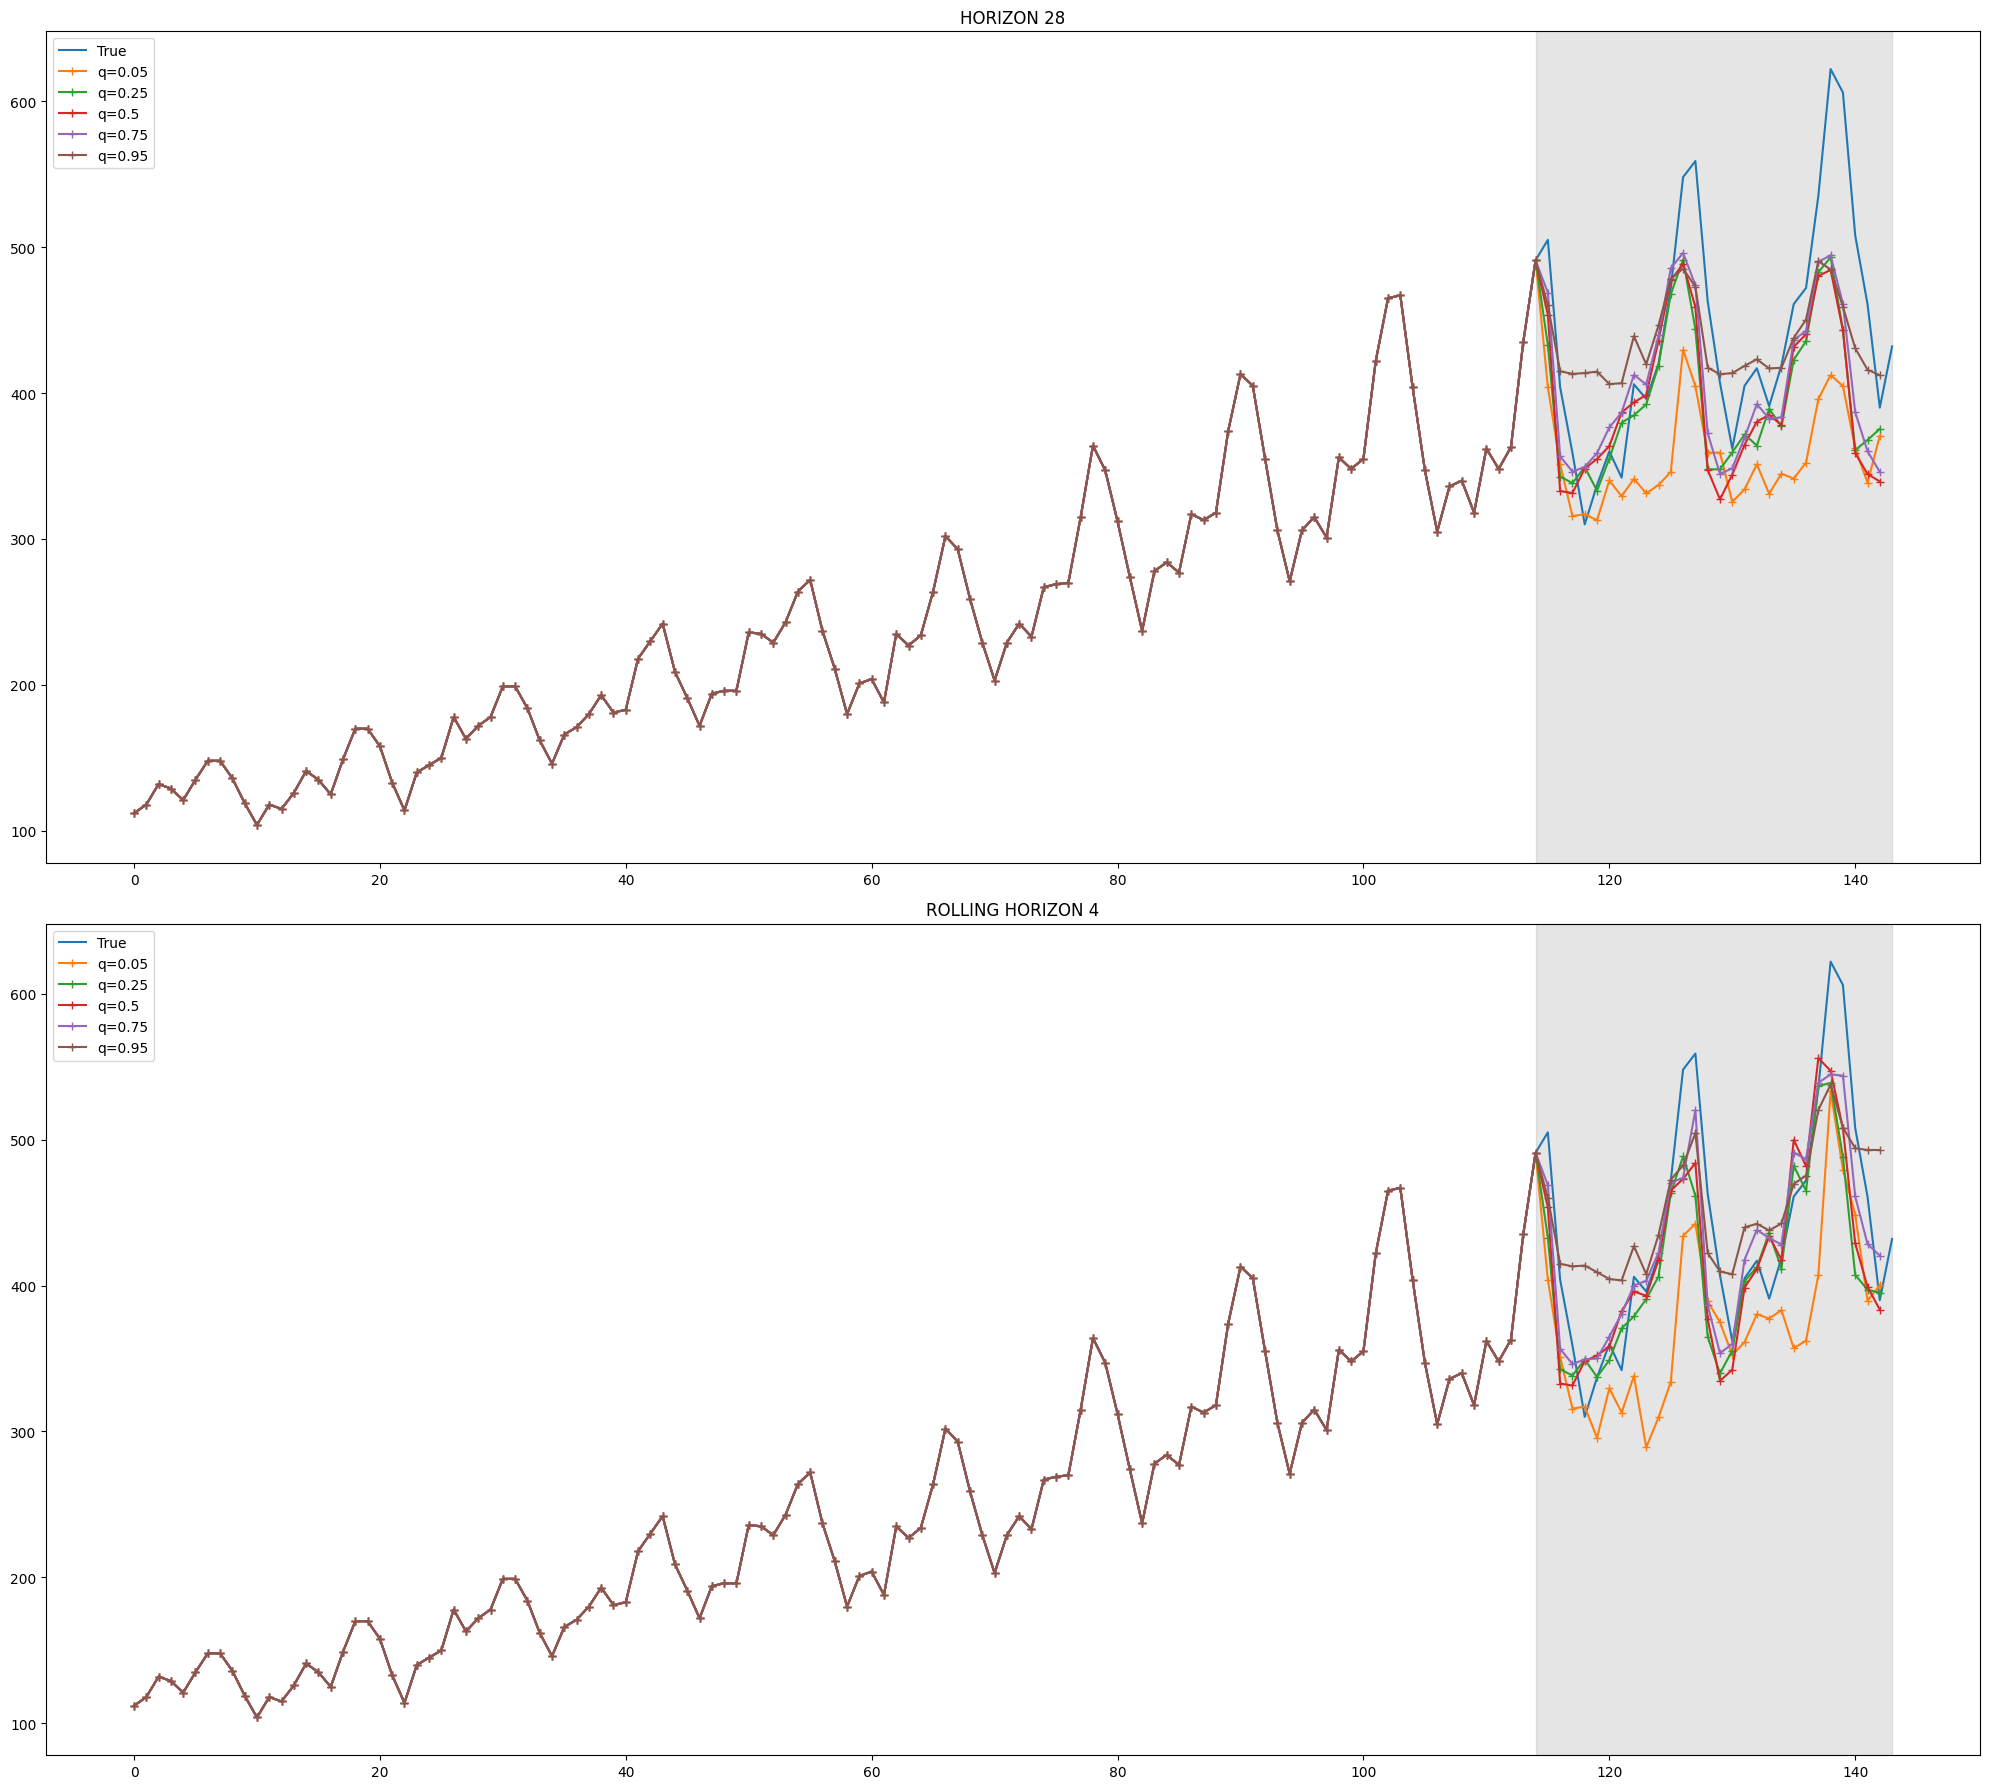

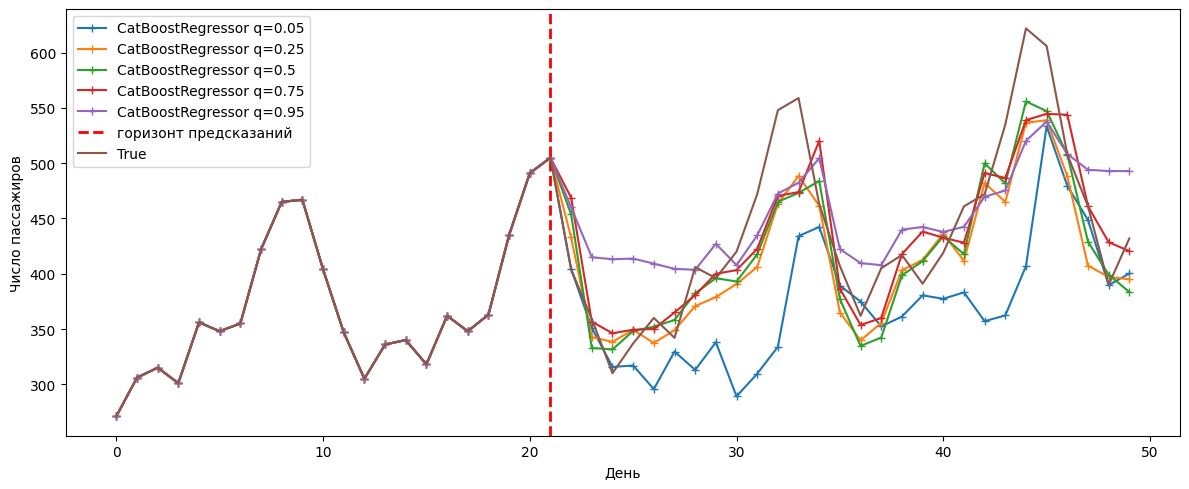

In [51]:
from sklearn.metrics import mean_pinball_loss, mean_absolute_error

print('HORIZON 28')
for quantile in QUANTILES:
    print(f'pl alpha={quantile}: {mean_pinball_loss(y_test, predictions[quantile], alpha=quantile)}')

print(f"ROLLING HORIZON {HORIZON}")
for quantile in QUANTILES:
    print(f'pl alpha={quantile}: {mean_pinball_loss(y[-28:], rolling_predictions[quantile], alpha=quantile)}')


fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].plot(y, label='True')
ax[0].set_title('HORIZON 28')
for quantile in QUANTILES:
    ax[0].plot(np.concatenate((df["target"][:-28], predictions[quantile])), '+-',label=f'q={quantile}')
ax[0].axvspan(len(y_train) - 1, len(y) - 1, color='#808080', alpha=0.2)
ax[0].legend()

ax[1].plot(y, label='True')
ax[1].set_title(f"ROLLING HORIZON {HORIZON}")
for quantile in QUANTILES:
    ax[1].plot(np.concatenate((df["target"][:-28], rolling_predictions[quantile])), '+-',label=f'q={quantile}')
ax[1].axvspan(len(y_train) - 1, len(y) - 1, color='#808080', alpha=0.2)
ax[1].legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for quantile in QUANTILES:
    plt.plot(np.concatenate((train_data, list(rolling_predictions[quantile])))[-50:], '+-',label=f'CatBoostRegressor q={quantile}')
plt.axvline(x=21, color='r', linestyle='--', linewidth=2, label='горизонт предсказаний')
plt.plot(y[-50:], label='True')
plt.xlabel('День')
plt.ylabel('Число пассажиров')

plt.legend()
plt.tight_layout()
plt.show()


In [52]:
print(f'rolling ARIMA {max(q, 1)}\n{pl(y[-28:], rolling_quantile_pred)}\n')

vincentization = {}
# [2.73138134 5.86495555 7.13782285 5.4400992  2.34194916]
# pl alpha=0.05: 4.339947137053337
# pl alpha=0.25: 14.299798495670386
# pl alpha=0.5: 27.14007627347751
# pl alpha=0.75: 30.555069187484417
# pl alpha=0.95: 23.80353341080516
print(f'rolling arima {max(q, 1)} + GBDT 28')
for quantile in QUANTILES:
    vincentization[quantile] = [np.mean(preds) for preds in zip(predictions[quantile], rolling_quantile_pred.to_dict()[(0, quantile)].values())]

from sklearn.metrics import mean_pinball_loss, mean_absolute_error

for quantile in QUANTILES:
    print(f'pl alpha={quantile}: {mean_pinball_loss(y_test[-28:], vincentization[quantile], alpha=quantile):.4f}')
print()
print(f'rolling arima {max(q, 1)} + GBDT {HORIZON}')
vincentization = {}
# [2.73138134 5.86495555 7.13782285 5.4400992  2.34194916]
# pl alpha=0.05: 4.339947137053337
# pl alpha=0.25: 14.299798495670386
# pl alpha=0.5: 27.14007627347751
# pl alpha=0.75: 30.555069187484417
# pl alpha=0.95: 23.80353341080516
for quantile in QUANTILES:
    vincentization[quantile] = [np.mean(preds) for preds in zip(rolling_predictions[quantile], rolling_quantile_pred.to_dict()[(0, quantile)].values())]

from sklearn.metrics import mean_pinball_loss, mean_absolute_error

for quantile in QUANTILES:
    print(f'pl alpha={quantile}: {mean_pinball_loss(y_test[-28:], vincentization[quantile], alpha=quantile):.4f}')

rolling ARIMA 1
0.05    2.731381
0.25    5.864956
0.50    7.137823
0.75    5.440099
0.95    2.341949
Name: 0, dtype: float64

rolling arima 1 + GBDT 28
pl alpha=0.05: 2.9119
pl alpha=0.25: 8.2309
pl alpha=0.5: 13.6920
pl alpha=0.75: 14.7786
pl alpha=0.95: 10.3521

rolling arima 1 + GBDT 4
pl alpha=0.05: 2.5075
pl alpha=0.25: 7.7828
pl alpha=0.5: 10.7605
pl alpha=0.75: 10.6864
pl alpha=0.95: 7.8168


In [185]:
# import seaborn as sns

# for alpha, grid_search in gird_search_results:
#     results_df = grid_search.cv_results_
#     best_model = grid_search.best_estimator_

#     pivot = results_df.pivot_table(
#         values='mean_test_score',
#         index='param_depth',
#         columns='param_learning_rate'
#     )
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
#     plt.title('Тепловая карта pinball loss в зависимости от depth и learning_rate')
#     plt.xlabel('Learning Rate')
#     plt.ylabel('Depth')
#     plt.show()
#     plt.savefig(f'{alpha}_heatmap.png')

#     # 6.2. График важности признаков
#     feature_importances = pd.Series(
#         best_model.get_feature_importance(),
#         index=X.columns
#     ).sort_values(ascending=False)

#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=feature_importances, y=feature_importances.index)
#     plt.title('Важность признаков по версии лучшей модели CatBoost')
#     plt.xlabel('Важность')
#     plt.ylabel('Признак')
#     plt.show()
#     plt.savefig(f'{alpha}_feature_importance.png')


In [186]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_pinball_loss, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

def prepare_prophet_data(y, train_size=0.8):
    """
    Подготовка данных для Prophet
    """

    dates = pd.date_range(
        start="2020-01-01", 
        periods=len(y), 
        freq='D'
    )
    
    # Создаем DataFrame в формате Prophet
    prophet_df = pd.DataFrame({
        'ds': dates,
        'y': y.values
    })
        
    # Разделяем на train/test
    split_idx = int(len(prophet_df) * train_size)
    train_df = prophet_df.iloc[:split_idx]
    test_df = prophet_df.iloc[split_idx:]
    
    return train_df, test_df, prophet_df

def prophet_quantile_forecast(train_df, test_df, quantiles):
    """
    Квантильное прогнозирование с помощью Prophet
    """
    models = {}
    forecasts = {}
    
    for alpha in quantiles:
        print(f"Обучаем Prophet для квантиля {alpha}...")
        
        # Создаем и настраиваем модель Prophet
        model = Prophet(
            # changepoint_prior_scale=0.05,
            seasonality_prior_scale=10.0,
            # holidays_prior_scale=10.0,
            seasonality_mode='additive',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False,
            interval_width=1 - 2 * abs(0.5 - alpha)  # Настраиваем ширину интервала
        )
        
        # Добавляем дополнительные регуляризаторы
        model.add_country_holidays(country_name='RU')  # Российские праздники
        
        # Обучаем модель
        model.fit(train_df)
        
        # Создаем будущие даты (включая тестовый период)
        future = model.make_future_dataframe(periods=len(test_df))
        
        # Прогнозируем
        forecast = model.predict(future)
        
        models[alpha] = model
        forecasts[alpha] = forecast
        
        print(f"  Завершено для квантиля {alpha}")
    
    return models, forecasts

def extract_prophet_predictions(forecasts, test_df, quantiles):
    """
    Извлекаем прогнозы для тестового периода
    """
    predictions = {}
    
    for alpha in quantiles:
        forecast = forecasts[alpha]
        
        # Сопоставляем прогнозы с тестовыми датами
        test_forecast = forecast[forecast['ds'].isin(test_df['ds'])]
        
        # Для квантилей используем yhat_lower и yhat_upper
        if alpha == 0.5:
            predictions[alpha] = test_forecast['yhat'].values
        elif alpha < 0.5:
            predictions[alpha] = test_forecast['yhat_lower'].values
        else:  # alpha > 0.5
            predictions[alpha] = test_forecast['yhat_upper'].values
    
    return predictions

def plot_prophet_results(models, forecasts, train_df, test_df, quantiles):
    """
    Визуализация результатов Prophet
    """
    # 1. Основной график прогнозов
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # График для медианной модели
    model_05 = models[0.5]
    forecast_05 = forecasts[0.5]
    
    model_05.plot(forecast_05, ax=axes[0, 0])
    axes[0, 0].plot(test_df['ds'], test_df['y'], 'r.', label='Факт (test)')
    axes[0, 0].set_title('Prophet: Прогноз медианы с компонентами')
    axes[0, 0].legend()
    
    # График компонентов (ИСПРАВЛЕНО - убрали ax)
    fig_components = model_05.plot_components(forecast_05)
    axes[0, 1].set_title('Компоненты временного ряда')
    # Переносим компоненты на нужные оси
    if hasattr(fig_components, 'get_axes'):
        comp_axes = fig_components.get_axes()
        for comp_ax in comp_axes:
            comp_fig = comp_ax.get_figure()
            comp_fig.savefig('temp_components.png')  # временное сохранение
            # Здесь можно добавить логику переноса изображения на axes[0, 1]
    plt.close('all')  # закрываем временные фигуры
    
    # Сравнение квантилей
    test_dates = test_df['ds']
    axes[1, 0].plot(test_dates, test_df['y'], 'b-', label='Факт', linewidth=2)
    
    colors = ['red', 'green', 'orange']
    for idx, alpha in enumerate(quantiles):
        pred = extract_prophet_predictions(forecasts, test_df, [alpha])[alpha]
        axes[1, 0].plot(test_dates, pred, '--', 
                       color=colors[idx], label=f'Квантиль {alpha}', alpha=0.8)
    
    axes[1, 0].set_title('Сравнение квантильных прогнозов Prophet')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Ошибки прогноза
    predictions = extract_prophet_predictions(forecasts, test_df, quantiles)
    errors = test_df['y'].values - predictions[0.5]
    axes[1, 1].hist(errors, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(x=0, color='red', linestyle='--')
    axes[1, 1].set_title('Распределение ошибок (медианная модель)')
    axes[1, 1].set_xlabel('Ошибка')
    axes[1, 1].set_ylabel('Частота')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Детальный график тестового периода
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, test_df['y'], 'b-', label='Факт', linewidth=2)
    
    # Заливаем область между квантилями
    pred_lower = extract_prophet_predictions(forecasts, test_df, [0.05])[0.05]
    pred_upper = extract_prophet_predictions(forecasts, test_df, [0.95])[0.95]
    
    plt.fill_between(test_dates, pred_lower, pred_upper, 
                    alpha=0.3, color='gray', label='90% интервал')
    plt.plot(test_dates, predictions[0.5], 'r--', label='Медиана', linewidth=2)
    
    plt.title('Prophet: Квантильные прогнозы на тестовом периоде')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. Отдельный график компонентов (ИСПРАВЛЕННАЯ ВЕРСИЯ)
    print("Строим компоненты временного ряда...")
    model_05.plot_components(forecast_05)
    plt.suptitle('Компоненты временного ряда Prophet', y=1.02)
    plt.tight_layout()
    plt.show()

# ОСНОВНОЙ ПРОЦЕСС
print("="*50)
print("ПРОГНОЗИРОВАНИЕ С ПОМОЩЬЮ PROPHET")
print("="*50)

# Подготовка данных
print("Подготавливаем данные для Prophet...")
y = pd.read_csv('air-passengers.csv')['Passengers']
train_df, test_df, full_df = prepare_prophet_data(y, train_size=0.8)

print(f"Размеры данных:")
print(f"Train: {len(train_df)} записей")
print(f"Test: {len(test_df)} записей")

# Обучение моделей
print("\nОбучаем Prophet модели...")
quantiles = QUANTILES
models, forecasts = prophet_quantile_forecast(train_df, test_df, quantiles)

# Извлекаем прогнозы
print("\nИзвлекаем прогнозы...")
predictions = extract_prophet_predictions(forecasts, test_df, quantiles)

# Оценка качества
print("\n" + "="*50)
print("ОЦЕНКА КАЧЕСТВА PROPHET")
print("="*50)

y_test = test_df['y'].values

for alpha in quantiles:
    loss = mean_pinball_loss(y_test, predictions[alpha], alpha=alpha)
    print(f'Pinball loss (alpha={alpha}): {loss:.4f}')

mae_score = mean_absolute_error(y_test, predictions[0.5])
print(f"MAE (медиана): {mae_score:.4f}")

# Проверка покрытия интервалов
coverage = np.mean((y_test >= predictions[0.05]) & (y_test <= predictions[0.95]))
print(f"Покрытие 85% интервала: {coverage:.2%}")

# Сравнение с бейзлайном
naive_pred = np.full_like(y_test, train_df['y'].iloc[-1])
naive_mae = mean_absolute_error(y_test, naive_pred)
print(f"\nСравнение с бейзлайном:")
print(f"Naive MAE: {naive_mae:.4f}")
print(f"Prophet MAE: {mae_score:.4f}")
print(f"Улучшение: {(1 - mae_score/naive_mae)*100:.1f}%")

# Визуализация
print("\n" + "="*50)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*50)

plot_prophet_results(models, forecasts, train_df, test_df, quantiles)

# Дополнительный анализ: тюнинг параметров
def tune_prophet_parameters(train_df, test_df):
    """
    Простой подбор параметров Prophet
    """
    param_combinations = [
        {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0},
        {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0},
        {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0},
        {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}
    ]
    
    best_mae = float('inf')
    best_params = None
    
    for params in param_combinations:
        print(f"Тестируем параметры: {params}")
        
        model = Prophet(**params)
        model.fit(train_df)
        future = model.make_future_dataframe(periods=len(test_df))
        forecast = model.predict(future)
        
        # Извлекаем прогнозы для тестового периода
        test_forecast = forecast[forecast['ds'].isin(test_df['ds'])]
        pred = test_forecast['yhat'].values
        mae = mean_absolute_error(test_df['y'].values, pred)
        
        print(f"  MAE: {mae:.4f}")
        
        if mae < best_mae:
            best_mae = mae
            best_params = params
    
    print(f"\nЛучшие параметры: {best_params}")
    print(f"Лучший MAE: {best_mae:.4f}")
    
    return best_params

# Опционально: тюнинг параметров
print("\n" + "="*50)
print("ТЮНИНГ ПАРАМЕТРОВ PROPHET")
print("="*50)

# best_params = tune_prophet_parameters(train_df, test_df)

# Анализ аномалий
def detect_anomalies(forecast):
    """
    Обнаружение аномалий с помощью Prophet
    """
    fig = plt.figure(figsize=(10, 6))
    
    # Добавляем аномалии (точки, где факт выходит за пределы интервала)
    anomaly_condition = (full_df['y'] > forecast['yhat_upper']) | (full_df['y'] < forecast['yhat_lower'])
    anomalies = full_df[anomaly_condition]
    
    plt.plot(full_df['ds'], full_df['y'], 'b-', label='Факт', alpha=0.7)
    plt.plot(forecast['ds'], forecast['yhat'], 'r-', label='Прогноз')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                    alpha=0.3, color='gray', label='Доверительный интервал')
    plt.plot(anomalies['ds'], anomalies['y'], 'ro', label='Аномалии')
    
    plt.title('Обнаружение аномалий с помощью Prophet')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return anomalies

# Обнаружение аномалий на полном наборе данных
print("\nАнализ аномалий...")
full_forecast = forecasts[0.5]  # Используем медианную модель
anomalies = detect_anomalies(full_forecast)
print(f"Обнаружено аномалий: {len(anomalies)}")

# Сохранение результатов
def save_prophet_results(forecasts, test_df, predictions, file_prefix='prophet'):
    """
    Сохранение результатов Prophet
    """
    # Создаем DataFrame с результатами
    results_df = test_df.copy()
    results_df['pred_median'] = predictions[0.5]
    results_df['pred_lower'] = predictions[0.05]
    results_df['pred_upper'] = predictions[0.95]
    results_df['error'] = results_df['y'] - results_df['pred_median']
    
    # Сохраняем в CSV
    results_df.to_csv(f'{file_prefix}_results.csv', index=False)
    print(f"Результаты сохранены в {file_prefix}_results.csv")
    
    return results_df

# Сохраняем результаты
results_df = save_prophet_results(forecasts, test_df, predictions)

print("\n" + "="*50)
print("PROPHET ЗАВЕРШЕН УСПЕШНО!")
print("="*50)

ПРОГНОЗИРОВАНИЕ С ПОМОЩЬЮ PROPHET
Подготавливаем данные для Prophet...
Размеры данных:
Train: 115 записей
Test: 29 записей

Обучаем Prophet модели...
Обучаем Prophet для квантиля 0.05...


16:47:05 - cmdstanpy - INFO - Chain [1] start processing
16:47:06 - cmdstanpy - INFO - Chain [1] done processing


  Завершено для квантиля 0.05
Обучаем Prophet для квантиля 0.25...


16:47:06 - cmdstanpy - INFO - Chain [1] start processing
16:47:07 - cmdstanpy - INFO - Chain [1] done processing


  Завершено для квантиля 0.25
Обучаем Prophet для квантиля 0.5...


16:47:07 - cmdstanpy - INFO - Chain [1] start processing
16:47:07 - cmdstanpy - INFO - Chain [1] done processing


  Завершено для квантиля 0.5
Обучаем Prophet для квантиля 0.75...


16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] done processing


  Завершено для квантиля 0.75
Обучаем Prophet для квантиля 0.95...


16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing


  Завершено для квантиля 0.95

Извлекаем прогнозы...

ОЦЕНКА КАЧЕСТВА PROPHET
Pinball loss (alpha=0.05): 20.3458
Pinball loss (alpha=0.25): 20.0573
Pinball loss (alpha=0.5): 27.9151
Pinball loss (alpha=0.75): 27.3283
Pinball loss (alpha=0.95): 31.3120
MAE (медиана): 55.8302
Покрытие 85% интервала: 10.34%

Сравнение с бейзлайном:
Naive MAE: 81.4483
Prophet MAE: 55.8302
Улучшение: 31.5%

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


IndexError: list index out of range

In [ ]:
# from sktime.datasets import load_airline
# from sktime.forecasting.arima import AutoARIMA, ARIMA
# from sklearn.metrics import root_mean_squared_error, r2_score
# from sktime.split import SlidingWindowSplitter
# # 1. Initial training on historical data (excluding last 28 points)
# model = ARIMA(order=(3,1,4), seasonal_order=(0,0,2,12), suppress_warnings=True)
# ID = "HOUSEHOLD_2_044_WI_3_evaluation"
# y = train_df[train_df["id"] == ID].filter(like='d_').values[0]
# model.fit(y[:-28])

# # 2. Rolling forecasts using update_predict with optimal settings
# cv = SlidingWindowSplitter(
#     window_length=len(y) - 28,  # Initial training window
#     step_length=4,              # Update every 4 steps (MA order)
#     fh=list(range(1, 5))        # Forecast 4 steps ahead each time
# )

# y_pred = model.update_predict(
#     y=y,                        # Full series (model will handle the split)
#     cv=cv,
#     update_params=True,         # Critical: update model parameters
#     reset_forecaster=False      # Maintain state between updates
# )

In [ ]:
# from sklearn.metrics import root_mean_squared_error, r2_score

# # non_update_model = ARIMA(order=(3,1,4), seasonal_order=(0,0,2,12), suppress_warnings=True)
# # non_update_model.fit(y[:-28])
# # non_update_pred = non_update_model.predict(fh=np.arange(28))

# # Compare with naive approach
# naive_pred = model.predict(fh=np.arange(28))

# y_pred_merged = pd.Series(index=y_pred.index, dtype=float)

# # Extract predictions from each batch
# for i, col in enumerate(y_pred.columns):
#     # Get non-NaN values from this column
#     valid_preds = y_pred[col].dropna()
#     # Add them to our merged series
#     y_pred_merged.loc[valid_preds.index] = valid_preds

# # Calculate RMSE for both methods
# rolling_rmse = root_mean_squared_error(y[-28:], y_pred_merged)
# naive_rmse = root_mean_squared_error(y[-28:], naive_pred)
# # non_update_rmse = root_mean_squared_error(y[-28:], non_update_pred)

# # print(f"None update forecast RMSE: {non_update_rmse:.4f}")
# print(f"Rolling Forecast RMSE: {rolling_rmse:.4f}")
# print(f"Naive 28-step RMSE: {naive_rmse:.4f}")

In [ ]:
# from sktime.datasets import load_airline
# from sktime.forecasting.arima import AutoARIMA
# from sklearn.metrics import root_mean_squared_error, r2_score

# PREDICT_HORIZON=28
# ARIMA_RANDOM_STATE=411
# indx_lst = [1337, 28581, 30426, 2810]
# y_lst = [train_df.iloc[ind].filter(like="d_").values for ind in indx_lst] + [passengers_df[col].values for col in passengers_df.filter(like='Passengers').columns]
# sp_lst = [0, 0, 52, 52, 12, 12, 12, 12]
# names_lst = [train_df.iloc[ind]["id"] for ind in indx_lst] + [col for col in passengers_df.filter(like='Passengers').columns]
# assert len(y_lst) == len(sp_lst) == len(names_lst) == 8

# results_dct = defaultdict(dict)
# for y, name in zip(y_lst, names_lst):
#     results_dct["name"].update({"y": y, "ph": PREDICT_HORIZON, "arima_random_state": ARIMA_RANDOM_STATE})
#     forecaster = AutoARIMA(
#         sp=12, max_p=10, max_q=10, suppress_warnings=True, random_state=411
#     ) 

#     forecaster.fit(y[:-PREDICT_HORIZON])  
#     y_pred = forecaster.predict(fh=np.arange(PREDICT_HORIZON))
#     results_dct["name"].update({"y_pred": y_pred})  

#     r2 = r2_score(y[-PREDICT_HORIZON:], y_pred)
#     rmse = root_mean_squared_error(y[-PREDICT_HORIZON:], y_pred)
#     results_dct["name"].update({"r2": r2, "rmse": rmse})
#     print(f'R2_score: {r2:.3f}')
#     print(f'RMSE: {rmse:.3f}')

#     y_df = pd.DataFrame({"y_true":y, "y_pred": np.concatenate((y[:-PREDICT_HORIZON], y_pred.flatten()))})
#     y_df.plot()
#     plt.savefig(f'pictures/{name}.png')

#     fitted_params = forecaster.get_fitted_params()
#     results_dct["name"].update({"fitted_params": fitted_params})

# with open('auto_arima_results.json', 'w') as json_file:
#     json.dump(results_dct, json_file, indent=4)
#     print(f"Результаты сохранены в {json_file.name}")

# Defining of corresponding time series

In [ ]:
# N_SERIES_TO_PROCESS = 1000
# sample_df = train_df.iloc[[30426, 0]]
# SEASONAL_PERIOD = 365  # Данные в M5 ежедневные, основная сезонность - недельная
# THRESHOLDS = {
#         'trend': 0.8,     # Сила тренда > 0.5 -> есть тренд
#         'season': 0.7,    # Сила сезонности > 0.5 -> есть сезонность
#         'clean': 0.85,     # Сила компоненты > 0.9 -> компонент "чистый" (мало шума)
#     }

# results = []
# for index, row in sample_df.iterrows():
#     series_id = row['id']
#     # Отбираем только столбцы с продажами (d_1, d_2, ...)
#     time_series = row.filter(like='d_').astype(float)
    
#     features = calculate_stl_features(time_series, period=SEASONAL_PERIOD)

#     if features:
#         classification = classify_series(features, THRESHOLDS)
#         results.append({
#             'id': series_id,
#             'classification': classification,
#             'trend_strength': features['trend_strength'],
#             'seasonal_strength': features['seasonal_strength'],
#             'noise_variance': features['noise_variance'],
#             'stl_result': features['stl_result'] # Сохраняем объект для графика
#         })

# stl_results_df = pd.DataFrame(results)
# print("--- Результаты классификации ---")
# display(stl_results_df[['id', 'classification', 'trend_strength', 'seasonal_strength']].head(10))
# print("\n--- Сводка по категориям ---")
# display(stl_results_df['classification'].value_counts())

# # ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ
# print("\n--- Визуализация примеров из каждой найденной категории ---")

# unique_classifications = stl_results_df['classification'].unique()
# for cat in unique_classifications:
#     # Находим первый ряд, соответствующий этой категории
#     example = stl_results_df[stl_results_df['classification'] == cat].iloc[0]
    
#     print(f"\nПример для категории: '{cat}' (ID: {example['id']})")
    
#     # Отрисовываем его STL-декомпозицию
#     fig = example['stl_result'].plot()
#     fig.suptitle(f"Категория: {cat}\nID: {example['id']}", y=1.02)
#     plt.show()

In [ ]:
# stl_results_df["classification"].value_counts()

In [ ]:
# classification_res = "Seasonality + Noise"
# indx_lst = []
# for id in stl_results_df[stl_results_df["classification"] == classification_res]["id"].values:
#     index = train_df[train_df["id"] == id].index.item()
#     indx_lst.append(index)
# display(stl_results_df[stl_results_df["classification"] == classification_res]["id"])
# print(indx_lst)
# plot_series(indx_lst)
# # plt.plot(train_df[train_df["id"] == "HOBBIES_1_003_CA_1_evaluation"].values)

